# Two-Phase Microstructure Phase Mapping — Final (Single Image)

**Pipeline:**
```
Median Filter → Background Subtraction → CLAHE → Gaussian Blur
  → Otsu Thresholding (2-class)
  → Morphological Cleaning (Open + Close)
  → Overlay & Colormap
  → Phase Fraction Bar Chart
  → Save
```
**Color legend:**
- 🔴 Red  → Light Phase
- 🔵 Blue → Dark Phase

---
## Parameters

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# ── Image path ────────────────────────────────────────
IMG_PATH = 'dss_2205/image/HO_12.png'

# ── Preprocessing ─────────────────────────────────────
MEDIAN_K   = 5       # Median filter kernel (odd int) — removes speckles
BG_SIGMA   = 80      # Background estimation sigma  — larger = broader illumination correction
CLAHE_CLIP = 3.0     # CLAHE clip limit             — higher = stronger local contrast
CLAHE_GRID = (8, 8)  # CLAHE tile size              — smaller = more local correction
GAUSS_K    = (5, 5)  # Gaussian smoothing kernel
GAUSS_SIG  = 1

# ── Morphological cleaning ────────────────────────────
OPEN_K     = 3       # Opening kernel  — removes small speckle remnants
OPEN_IT    = 2
CLOSE_K    = 5       # Closing kernel  — fills small holes inside phases
CLOSE_IT   = 2

# ── Area filtering ────────────────────────────────────
MIN_AREA_PIXELS = 200  # Minimum area size (pixels) — filter out dark phase regions smaller than this

# ── Overlay ───────────────────────────────────────────
ALPHA       = 0.45
COLOR_LIGHT = np.array([220,  50,  50], dtype=np.uint8)   # Red  — Light Phase
COLOR_DARK  = np.array([ 50,  80, 220], dtype=np.uint8)   # Blue — Dark Phase

# ── Output ────────────────────────────────────────────
OUTPUT_DIR  = Path('dss_2205/outputs/')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f'Image      : {Path(IMG_PATH).name}')
print(f'Output dir : {OUTPUT_DIR}')

Image      : HO_12.png
Output dir : dss_2205/outputs


---
## Step 1 — Load & Preprocess

Shape : (768, 768)   dtype : uint8


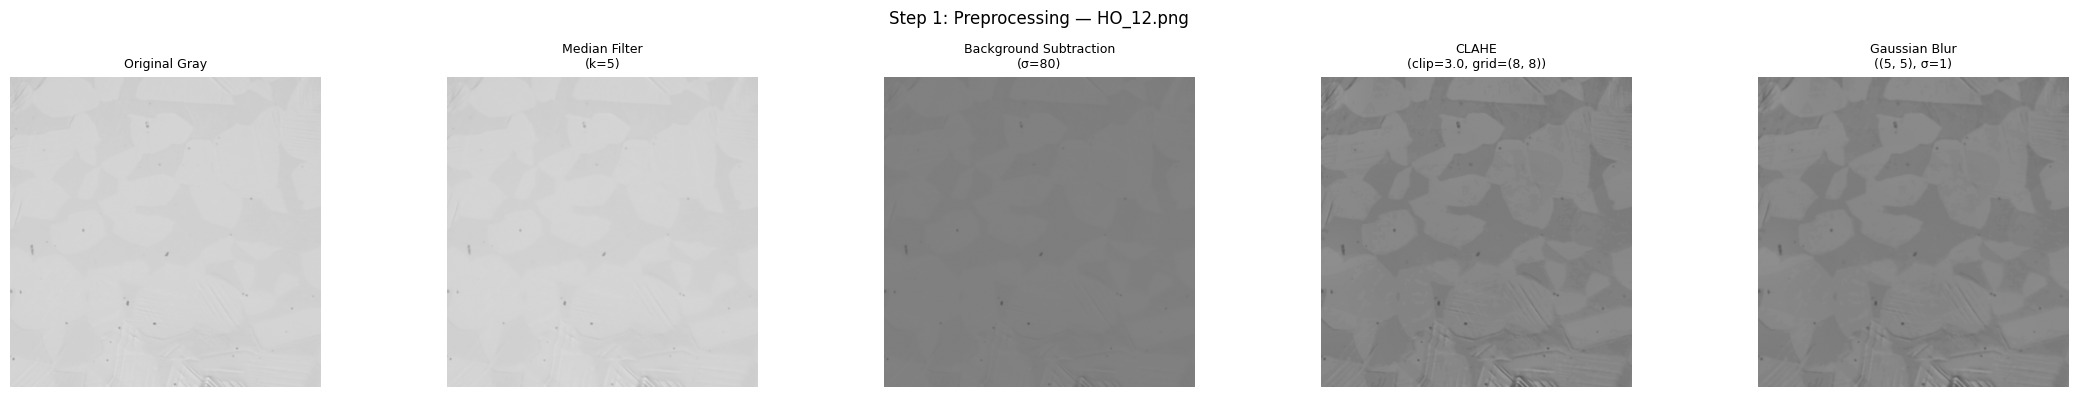

In [24]:
# ── Load ──────────────────────────────────────────────
img_bgr  = cv2.imread(IMG_PATH)
img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
print(f'Shape : {img_gray.shape}   dtype : {img_gray.dtype}')

# ── Median filter — speckle removal ───────────────────
img_med = cv2.medianBlur(img_gray, MEDIAN_K)

# ── Background subtraction — illumination correction ──
bg       = cv2.GaussianBlur(img_med, (0, 0), BG_SIGMA).astype(np.float32)
bg       = np.clip(bg, 1, None)
img_norm = (img_med.astype(np.float32) / bg * 128).clip(0, 255).astype(np.uint8)

# ── CLAHE — local contrast enhancement ────────────────
clahe     = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
img_clahe = clahe.apply(img_norm)

# ── Gaussian blur — final smoothing ───────────────────
img_smooth = cv2.GaussianBlur(img_clahe, GAUSS_K, GAUSS_SIG)

# ── Visualize ─────────────────────────────────────────
stages  = [img_gray, img_med, img_norm, img_clahe, img_smooth]
titles  = [
    'Original Gray',
    f'Median Filter\n(k={MEDIAN_K})',
    f'Background Subtraction\n(σ={BG_SIGMA})',
    f'CLAHE\n(clip={CLAHE_CLIP}, grid={CLAHE_GRID})',
    f'Gaussian Blur\n({GAUSS_K}, σ={GAUSS_SIG})'
]

fig, axes = plt.subplots(1, 5, figsize=(22, 4))
for ax, im, title in zip(axes, stages, titles):
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)
    ax.set_title(title, fontsize=9)
    ax.axis('off')
plt.suptitle(f'Step 1: Preprocessing — {Path(IMG_PATH).name}', fontsize=12)
plt.tight_layout()
plt.show()

---
## Step 2 — Otsu Thresholding

Otsu threshold : 130.0


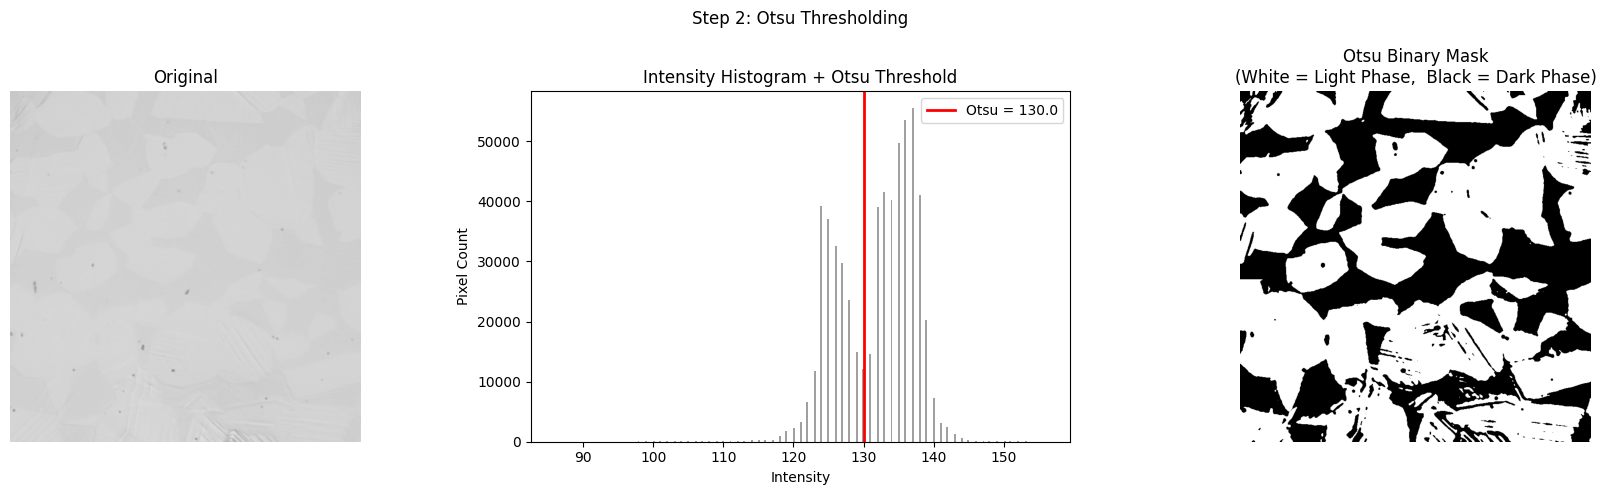

In [25]:
otsu_val, mask_otsu = cv2.threshold(
    img_smooth, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
print(f'Otsu threshold : {otsu_val:.1f}')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(img_rgb)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].hist(img_smooth.ravel(), bins=256, color='gray', alpha=0.75)
axes[1].axvline(otsu_val, color='red', lw=2, label=f'Otsu = {otsu_val:.1f}')
axes[1].set_title('Intensity Histogram + Otsu Threshold')
axes[1].set_xlabel('Intensity')
axes[1].set_ylabel('Pixel Count')
axes[1].legend(fontsize=10)

axes[2].imshow(mask_otsu, cmap='gray')
axes[2].set_title('Otsu Binary Mask\n(White = Light Phase,  Black = Dark Phase)')
axes[2].axis('off')

plt.suptitle('Step 2: Otsu Thresholding', fontsize=12)
plt.tight_layout()
plt.show()

---
## Step 3 — Morphological Cleaning

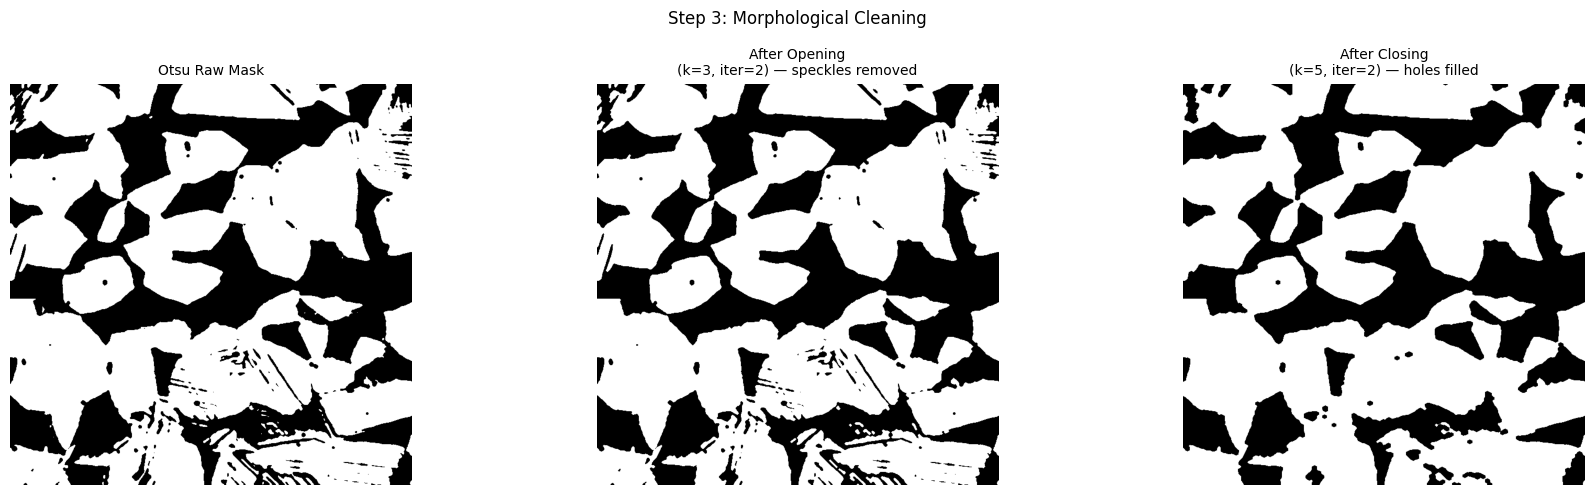

In [26]:
open_kernel  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (OPEN_K,  OPEN_K))
close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (CLOSE_K, CLOSE_K))

mask_opened = cv2.morphologyEx(mask_otsu,   cv2.MORPH_OPEN,  open_kernel,  iterations=OPEN_IT)
mask_clean  = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, close_kernel, iterations=CLOSE_IT)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, im, title in zip(
    axes,
    [mask_otsu, mask_opened, mask_clean],
    ['Otsu Raw Mask',
     f'After Opening\n(k={OPEN_K}, iter={OPEN_IT}) — speckles removed',
     f'After Closing\n(k={CLOSE_K}, iter={CLOSE_IT}) — holes filled']
):
    ax.imshow(im, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.suptitle('Step 3: Morphological Cleaning', fontsize=12)
plt.tight_layout()
plt.show()

---
## Step 3.5 — Filter Small Dark Phase Regions

Filtered out 18 small dark regions (area < 200 px)


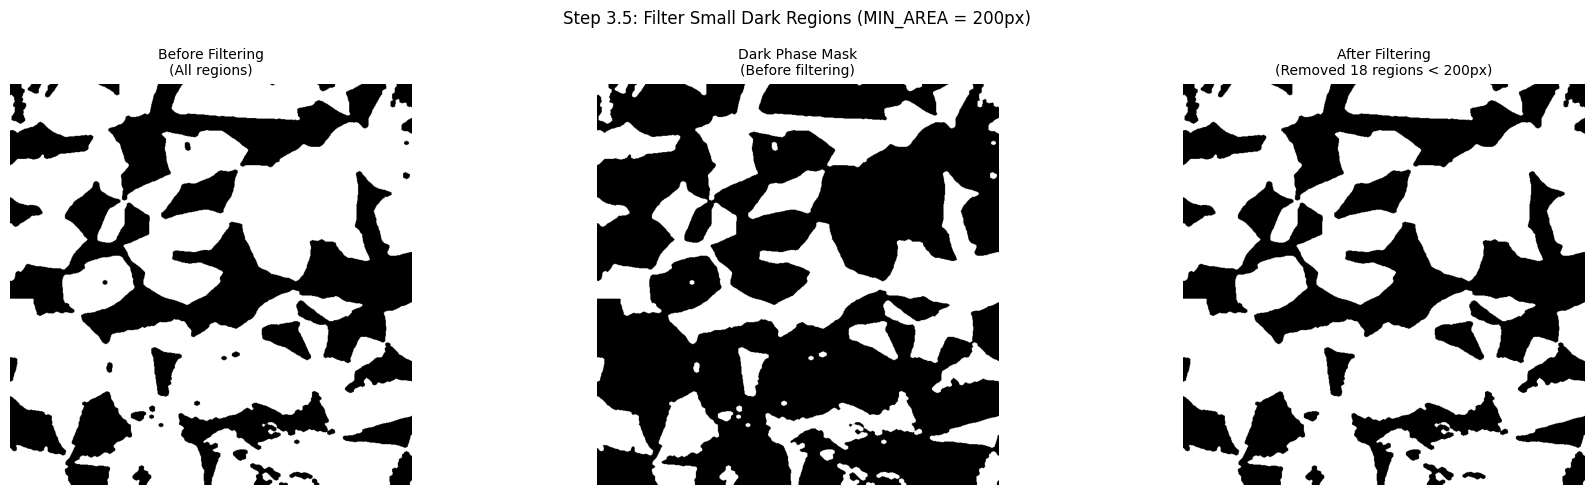

In [27]:
# Find contours in the dark phase (inverted mask: 0 = dark, 255 = light)
dark_phase_mask = (mask_clean == 0).astype(np.uint8) * 255
contours, hierarchy = cv2.findContours(dark_phase_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small regions
mask_filtered = mask_clean.copy()
small_regions_count = 0

for contour in contours:
    area = cv2.contourArea(contour)
    if area < MIN_AREA_PIXELS:
        # Fill small dark region with light phase (255)
        cv2.drawContours(mask_filtered, [contour], 0, 255, -1)
        small_regions_count += 1

print(f'Filtered out {small_regions_count} small dark regions (area < {MIN_AREA_PIXELS} px)')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(mask_clean, cmap='gray')
axes[0].set_title('Before Filtering\n(All regions)', fontsize=10)
axes[0].axis('off')

axes[1].imshow(dark_phase_mask, cmap='gray')
axes[1].set_title('Dark Phase Mask\n(Before filtering)', fontsize=10)
axes[1].axis('off')

axes[2].imshow(mask_filtered, cmap='gray')
axes[2].set_title(f'After Filtering\n(Removed {small_regions_count} regions < {MIN_AREA_PIXELS}px)', fontsize=10)
axes[2].axis('off')

plt.suptitle(f'Step 3.5: Filter Small Dark Regions (MIN_AREA = {MIN_AREA_PIXELS}px)', fontsize=12)
plt.tight_layout()
plt.show()

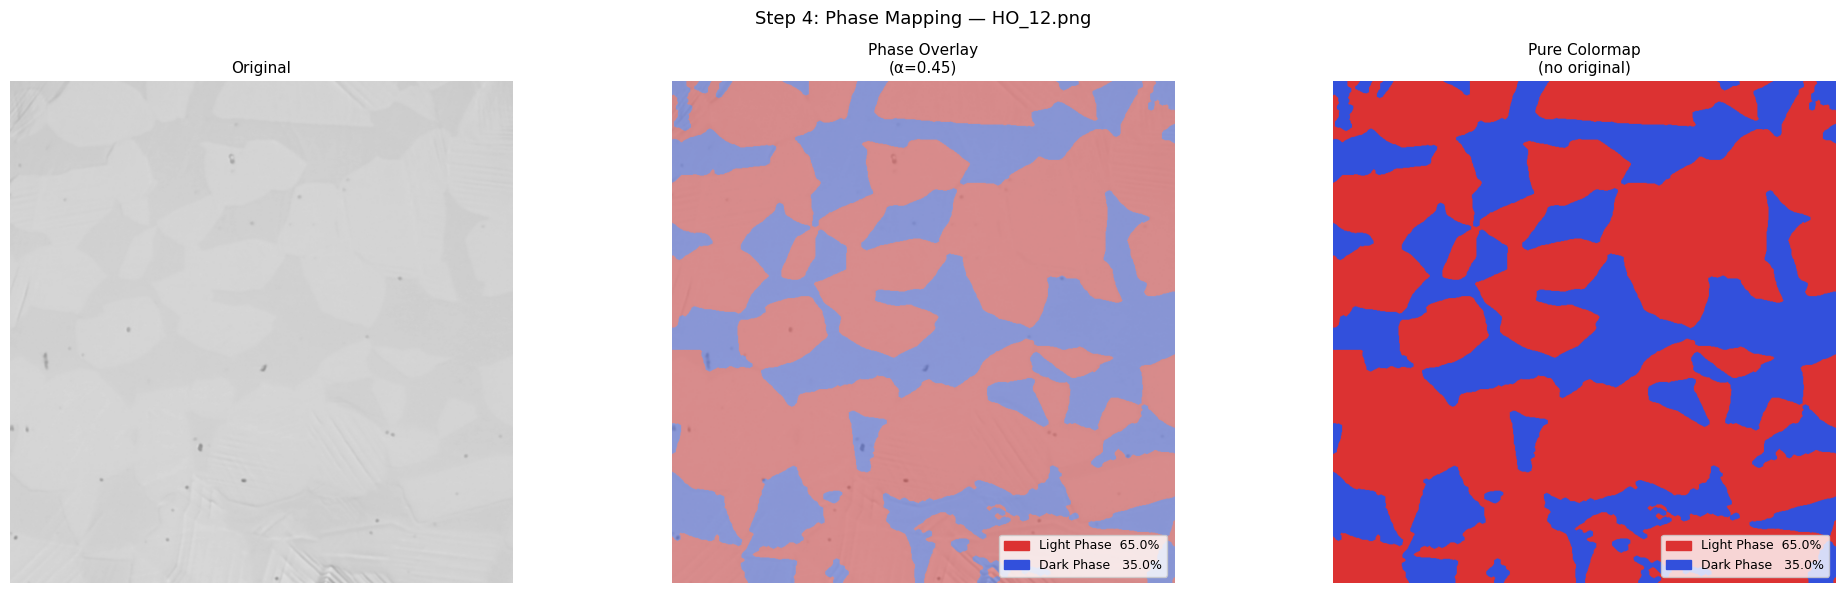

In [29]:
# Build pure colormap (no original image)
colormap = np.where(
    mask_filtered[..., None] == 255,
    COLOR_LIGHT,
    COLOR_DARK
).astype(np.uint8)

# Blend with original
overlay = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

# Phase fractions for legend
light_pct = np.sum(mask_filtered == 255) / mask_filtered.size * 100
dark_pct  = np.sum(mask_filtered == 0)   / mask_filtered.size * 100

legend = [
    mpatches.Patch(color=[c/255 for c in COLOR_LIGHT], label=f'Light Phase  {light_pct:.1f}%'),
    mpatches.Patch(color=[c/255 for c in COLOR_DARK],  label=f'Dark Phase   {dark_pct:.1f}%'),
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(img_rgb)
axes[0].set_title('Original', fontsize=11)
axes[0].axis('off')

axes[1].imshow(overlay)
axes[1].set_title(f'Phase Overlay\n(α={ALPHA})', fontsize=11)
axes[1].legend(handles=legend, loc='lower right', fontsize=9)
axes[1].axis('off')

axes[2].imshow(colormap)
axes[2].set_title('Pure Colormap\n(no original)', fontsize=11)
axes[2].legend(handles=legend, loc='lower right', fontsize=9)
axes[2].axis('off')

plt.suptitle(f'Step 4: Phase Mapping — {Path(IMG_PATH).name}', fontsize=13)
plt.tight_layout()
plt.show()

---
## Step 5 — Phase Fraction Bar Chart

=== Phase Fraction Results ===
  Light Phase : 71.63%
  Dark Phase  : 28.37%
  Total pixels: 589,824


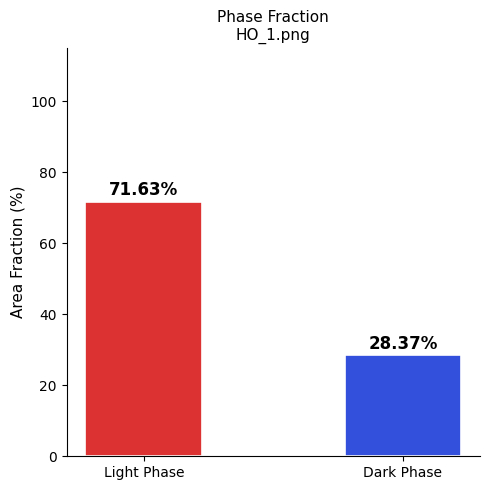

In [11]:
print('=== Phase Fraction Results ===')
print(f'  Light Phase : {light_pct:.2f}%')
print(f'  Dark Phase  : {dark_pct:.2f}%')
print(f'  Total pixels: {mask_clean.size:,}')

fig, ax = plt.subplots(figsize=(5, 5))
bars = ax.bar(
    ['Light Phase', 'Dark Phase'],
    [light_pct, dark_pct],
    color=[[c/255 for c in COLOR_LIGHT],
           [c/255 for c in COLOR_DARK]],
    width=0.45,
    edgecolor='white',
    linewidth=1.2
)
for bar, val in zip(bars, [light_pct, dark_pct]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.8,
        f'{val:.2f}%',
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )
ax.set_ylim(0, 115)
ax.set_ylabel('Area Fraction (%)', fontsize=11)
ax.set_title(f'Phase Fraction\n{Path(IMG_PATH).name}', fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

---
## Step 6 — Save Results

In [8]:
stem = Path(IMG_PATH).stem

overlay_path  = OUTPUT_DIR / f'{stem}_overlay.png'
colormap_path = OUTPUT_DIR / f'{stem}_colormap.png'

cv2.imwrite(str(overlay_path),
            cv2.cvtColor(overlay,  cv2.COLOR_RGB2BGR))

# Add phase percentage text to colormap
colormap_with_text = colormap.copy()
h, w = colormap_with_text.shape[:2]
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.2
thickness = 2
text_color = (255, 255, 255)  # White text in BGR

# Add text with background
text1 = f'Light Phase: {light_pct:.2f}%'
text2 = f'Dark Phase: {dark_pct:.2f}%'

# Get text size for background
(text_w1, text_h1), baseline1 = cv2.getTextSize(text1, font, font_scale, thickness)
(text_w2, text_h2), baseline2 = cv2.getTextSize(text2, font, font_scale, thickness)

y_offset = 40
# Background rectangles
cv2.rectangle(colormap_with_text, (10, y_offset - text_h1 - 5), (20 + text_w1, y_offset + baseline1), (0, 0, 0), -1)
cv2.rectangle(colormap_with_text, (10, y_offset + 40 - text_h2 - 5), (20 + text_w2, y_offset + 40 + baseline2), (0, 0, 0), -1)

# Add text
cv2.putText(colormap_with_text, text1, (15, y_offset), font, font_scale, text_color, thickness)
cv2.putText(colormap_with_text, text2, (15, y_offset + 40), font, font_scale, text_color, thickness)

cv2.imwrite(str(colormap_path),
            cv2.cvtColor(colormap_with_text, cv2.COLOR_RGB2BGR))

print('Saved:')
print(f'  {overlay_path.name}   — overlay on original image')
print(f'  {colormap_path.name}  — pure phase colormap with phase percentages')
print()
print(f'Light Phase : {light_pct:.2f}%')
print(f'Dark Phase  : {dark_pct:.2f}%')

Saved:
  10X_overlay.png   — overlay on original image
  10X_colormap.png  — pure phase colormap with phase percentages

Light Phase : 54.77%
Dark Phase  : 45.23%
